# CS530 HW8

#### Question 1. (4 points)

a. For classification trees, implement three functions to calculate the (1) cross-entropy, (2) Gini index, and (3) misclassification error. Assume binary classification (labels are 0’s and 1’s). The functions takes p_1, the probability of a record belong to class k=1, as input.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor as dtr
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
def cal_cross_entropy(p_1):
    cross_entropy = -np.sum(p_1*np.log(p_1))
    return cross_entropy

def cal_gini_index(p_1):
    gini_index = np.sum(p_1*(1-p_1))
    return gini_index

def cal_misclassification_error(p_1):
    mc_error = 1 - p_1
    return mc_error

b. Apply the three functions you implemented in 1a on the training test (train.csv) of the heart-disease dataset. Choose the 'age' variable as the root node. Use each value in the 'age' variable as the splitting value. Plot the cross entropy, Gini index, and misclassification error over age on the two child nodes after splitting.

In [3]:
# Your code goes here
train = pd.read_csv("train.csv", index_col = 0)
age = train['age'].values

xtrain1 = train.drop('target', axis = 1)
ytrain1 = train['target']

test = pd.read_csv("test.csv", index_col = 0)
xtest1 = test.drop('target', axis =1)
ytest1 = test['target']

def weighted_avg(g, left, right):
    avg = g[0]*(len(left)/(len(left) + len(right))) + g[1]*(len(right)/(len(right) + len(left)))
    return avg

def ugly_boi(data):
    gini_ind, entropy, mce = list(), list(), list()  
    for i in data['age'].values:
        fill1 = data['age'] < i
        left = data[fill1].dropna()
        count1 = list(left['target'].value_counts())
        if len(count1) == 2:
            p1_1 = count1[0]/(count1[0] + count1[1])
        else:
            pass

        fill2 = data['age'] >= i
        right = data[fill2].dropna()
        count2 = list(right['target'].value_counts())
        if len(count2) == 2:
            p1_2 = count2[0]/(count2[0] + count2[1])
        else: 
            pass
        
        g = [cal_gini_index(p1_1), cal_gini_index(p1_2)]
        gini = weighted_avg(g, left, right)
        gini_ind.append(gini)
        
        mce2 = [cal_misclassification_error(p1_1), cal_misclassification_error(p1_2)]
        m = weighted_avg(mce2, left, right)
        mce.append(m)
        
        entro = [cal_cross_entropy(p1_1), cal_cross_entropy(p1_2)]
        e = weighted_avg(entro, left, right)
        entropy.append(e)
    return gini_ind, mce, entropy

In [4]:
gini_ind, mce, entropy = ugly_boi(train)

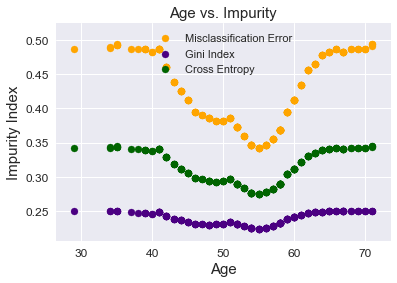

In [5]:
plt.scatter(age, mce, c = 'orange', label = 'Misclassification Error')
plt.scatter(age, gini_ind, c = 'indigo', label = 'Gini Index')
plt.scatter(age, entropy, c = 'darkgreen', label = 'Cross Entropy')
plt.xlabel("Age", fontsize = 15)
plt.ylabel("Impurity Index", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 11)
plt.title("Age vs. Impurity", fontsize = 15)
plt.show()

c. Discuss what you find in 1b. What age would you choose for the splitting value?

In [6]:
best_age = age[np.argmin(gini_ind)]
print("The best age to choose for the splitting value is", best_age)

The best age to choose for the splitting value is 55


In [7]:
# From the results in 1b, we can see that the Cross Entropy cost function varies similarly to the Gini Index, as expected.
# The best age to choose is in the 50's because they all result in low impurity index values, for example, we see a
# low Gini Index value, low Cross Entropy value, and low misclassification error value.  

#### Question 2. (3 points)

a. Implement a function to carry out the regression tree algorithm using the greedy approach. This implementation assumes the tree only splits twice. The function takes inputs X_train, y_train, and X_test, and return a prediction y_pred for X_test.

In [8]:
# This function returns the best initial splitting value for each step.
def best_split(mock): 
    col = [0,1,2]
    ind = []
    mins = []
    for i in col:
        total_rss = []
        for i in mock.iloc[:,0].values:
            fill1 = mock.iloc[:,0] < i
            left = mock[fill1]
            left_ytrain = left['y']
            left_ybar = np.mean(left_ytrain)
            
            fill2 = mock.iloc[:,0] >= i
            right = mock[fill2]
            right_ytrain = right['y']
            right_ybar = np.mean(right_ytrain)
            
            for j in left_ytrain:
                all_errors = []
                error_left = (j - left_ybar)**2
                all_errors.append(error_left)
            for j in right_ytrain:
                error_right = (j - right_ybar)**2
                all_errors.append(error_right)
            rss = np.sum(all_errors)
            total_rss.append(rss)
            
        mini = min(total_rss)
        mins.append(mini)
        
        ind.append(np.argmin(total_rss))
        s = np.argsort(mins)
        best_col = s[0]
        best_ind = ind[s[0]]
    return best_col, best_ind

In [9]:
def regression_tree(xtrain, ytrain, xtest):
    Xtrain = pd.DataFrame({'x1': xtrain[:,0], 'x2': xtrain[:,1], 'x3': xtrain[:,2], 'y': ytrain})
    Xtest = pd.DataFrame({'x1': xtest[:,0], 'x2': xtest[:,1], 'x3': xtest[:,2]})
    
    best_col, best_ind= best_split(Xtrain)
    
    left = Xtrain[Xtrain.iloc[:,best_col] < Xtrain.iloc[:,best_col][best_ind]]

    right = Xtrain[Xtrain.iloc[:,best_col] >= Xtrain.iloc[:,best_col][best_ind]]
    ypred1 = np.mean(right['y'])

    left_y = left['y']
    left_x = left.drop('y', axis = 1).values
    
    best_col2, best_ind2 = best_split(left)

    left2 = left[left.iloc[:,best_col2] < left.iloc[:,best_col2][best_ind2]]
    ypred2 = np.mean(left2['y'])

    right2 = left[left.iloc[:,best_col2] >= left.iloc[:,best_col2][best_ind2]]
    ypred3 = np.mean(right2['y'])
    
    ypred = []
    
    for i in Xtest.iloc[:,best_col]:
        if i >= Xtrain.iloc[:,best_col][best_ind]:
            ypred.append(ypred1)
    for j in Xtest.iloc[:,best_col2]:
        if j < left.iloc[:,best_col2][best_ind2]:
            ypred.append(ypred2)
        elif j >= left.iloc[:,best_col2][best_ind2]:
            ypred.append(ypred3)
    return ypred

b. Use the function you implemented in 2a to predict on the synthetic data below.

In [14]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# make a linearly separable dataset
X, y = make_regression(n_samples=1000,
                       n_features=3)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
# Your code goes here
ypred = regression_tree(xtrain, ytrain, xtest)

c. Do you think this implementation of the regression tree is a good model for this dataset? Explain.

In [ ]:
# No I don't. I think multi-variable linear regression would've performed better in a strictly continuous numerical featured
# dataset. Maybe pruning would've helped the results but I think regression tree would've been better had the dataset
# categorical along with numerical values. 

#### Question 3. (3 points)

a. Use the scikit-learn package to run Bagging and Random Forest on the heart-disease dataset and predict on its test set. Use cross-validation to find the best parameters for these algorithms.

In [46]:
# Your code goes here
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

seed = 7
num_trees = 10

col = xtrain1.columns
bag, randomforrest = list(), list()

for i in col:
    newxtrain = (xtrain1[i].values).reshape(-1,1)
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cart = DecisionTreeClassifier()
    model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state = seed)
    results = model_selection.cross_val_score(model, newxtrain, ytrain1, cv=kfold, error_score='raise')
    bag.append(results.mean())
    
    kfold = model_selection.KFold(n_splits=10, random_state= seed)
    model = RandomForestClassifier(n_estimators=10, max_features=1)
    results2 = model_selection.cross_val_score(model, newxtrain, ytrain1, cv=kfold)
    randomforrest.append(results2.mean())

In [12]:
np.argmax(bag)
np.argmax(randomforrest)
# The 13th column is the best parameter to use. :P

12

b. On the same axes, plot the ROC curves for the two algorithms with the best parameters that you found in 3a. Annotate their AUC values and compare their performance. 

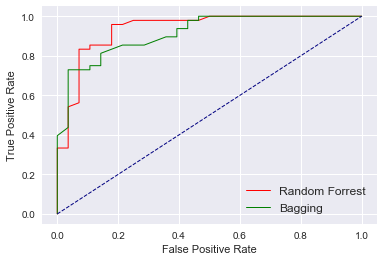

The AUC for Random Forrest is 0.9364
The AUC for Bagging is 0.9129


In [44]:
from sklearn.metrics import roc_auc_score
model1 = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model2 = BaggingClassifier(n_estimators=100, 
                               bootstrap = True
                               )
model1.fit(xtrain1,ytrain1)
model2.fit(xtrain1,ytrain1)

pred1 = model1.predict(xtest1)
ylogprob1 = model1.predict_proba(xtest1)[:, 1]

pred2 = model2.predict(xtest1)
ylogprob2 = model2.predict_proba(xtest1)[:,1]

roc_value1 = roc_auc_score(ytest1, pred1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(ytest1, ylogprob1)
auc1 = metrics.auc(fpr1,tpr1)

roc_value2 = roc_auc_score(ytest1, pred2)
fpr2, tpr2, thresholds2 = metrics.roc_curve(ytest1, ylogprob2)
auc2 = metrics.auc(fpr2,tpr2)

plt.plot(fpr1, tpr1, 'r-', lw = 1, label = 'Random Forrest')
plt.plot(fpr2, tpr2, 'g-', lw = 1, label = 'Bagging')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize = 12)
plt.show()

print("The AUC for Random Forrest is",round(auc1,4))
print("The AUC for Bagging is", round(auc2,4))

c. Explain your results in 3b. Why might the results vary across algorithms?

In [ ]:
# Your discussion goes here

# Random Forrest is an improvement because with RF, a tree can only be split on a random subset of the predictors.  This 
# results in more decorrelated trees that could better search potential splits in feature space. Due to this improvement,
# we see a greater AUC value of 0.9364 for the RF method, as a higher AUC indicates greater accuracy